In [1]:
import time
from pathlib import Path
from operator import itemgetter

import scanpy as sc
import numpy as np
import pandas as pd
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.sparse import csr_matrix
from joblib import Parallel, delayed
import os
import torch

import scSLAT
from scSLAT.model import Cal_Spatial_Net, load_anndatas, run_SLAT_mlp_AGF, spatial_match, run_SLAT, compute_lisi_for_adata, run_SLAT_AGF_contrast
from scSLAT.viz import match_3D_multi, hist, Sankey, build_3D
from scSLAT.metrics import region_statistics

In [2]:
adata_1=sc.read_h5ad(r"D:\ppppaper\data\Result\BRCA_S2.h5ad")
adata_1.var_names_make_unique(join="++")
adata_1

AnnData object with n_obs × n_vars = 3987 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'Cell_type', 'tumor_region_real', 'tumor_region', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'Spatial_Net', 'spatial', 'tumor_region_colors', 'tumor_region_real_colors'
    obsm: 'scSLAT_bks', 'spatial'

In [3]:
adata_2=sc.read_h5ad(r"D:\ppppaper\data\Result\BRCA_S1.h5ad")
adata_2.var_names_make_unique(join="++")
adata_2

AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'Cell_type', 'tumor_region', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'Cell_type_colors', 'Spatial_Net', 'spatial'
    obsm: 'scSLAT_bks', 'spatial'

In [5]:
adata_com = sc.concat([adata_1, adata_2], label='slice_name', keys=['slice_1', 'slice_2'])
sc.pp.neighbors(adata_com, use_rep= 'scSLAT_bks')
sc.tl.umap(adata_com)

d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
d:\Anaconda\envs\scSLAT\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


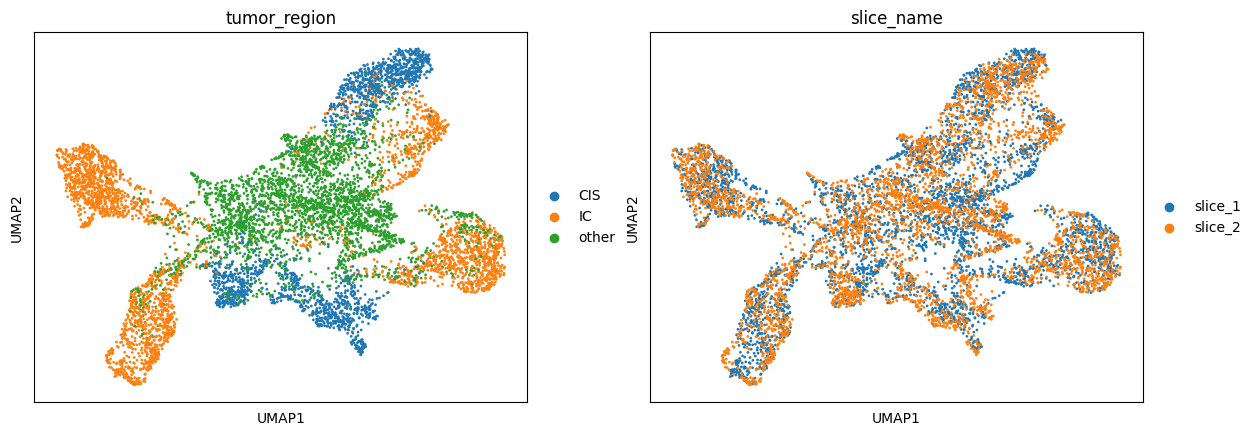

In [6]:
sc.pl.umap(adata_com, color= ['tumor_region','slice_name'])

d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


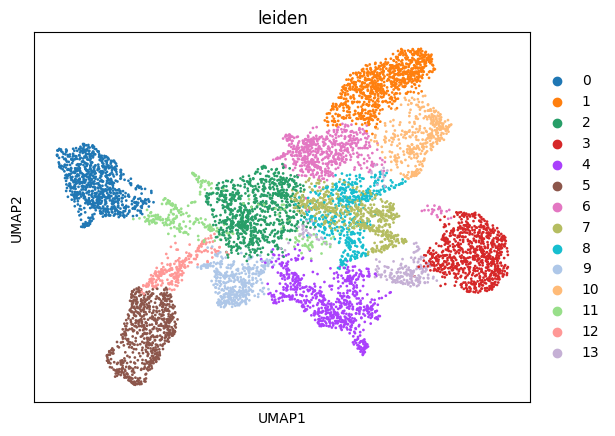

14

In [7]:
sc.pp.neighbors(adata_com, use_rep= 'scSLAT_bks', random_state= 666)
sc.tl.leiden(adata_com, resolution=0.67)

sc.pl.umap(adata_com, color=['leiden'])
len(adata_com.obs.leiden.cat.categories)

In [8]:
spot_size = 200
pathology_color = [
    "#1F77B4", "#FF7F0E", "#2CA02C", "#D62728", "#9467BD", "#8C564B",
    "#E377C2", "#7F7F7F", "#BCBD22", "#17BECF", "#AEC7E8", "#FFBB78",
    "#98DF8A", "#FF9896", "#C5B0D5", "#C49C94", "#F7B6D2", "#C7C7C7",
    "#DBDB8D", "#9EDAE5", "#1F9B99", "#FFCD56", "#33A02C", "#FB9A99",
    "#A6CEE3"
]


d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list


[<AxesSubplot: xlabel='spatial1', ylabel='spatial2'>]

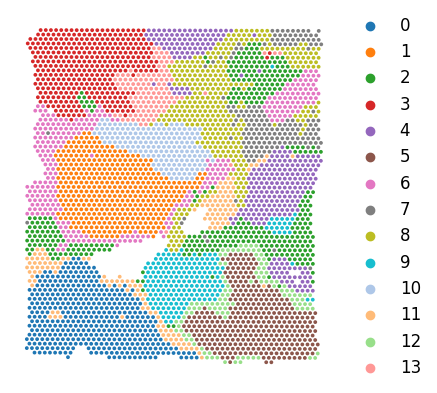

In [9]:
sc.pl.spatial(adata_com[0:3987,:], img_key=None, color=['leiden'], title=[''],
                legend_fontsize=12, show=False, frameon=False, palette=pathology_color,
                spot_size=spot_size)

d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list


[<AxesSubplot: xlabel='spatial1', ylabel='spatial2'>]

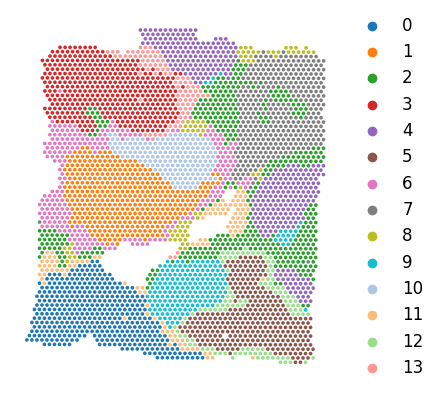

In [10]:
sc.pl.spatial(adata_com[3987:7785,:], img_key=None, color=['leiden'], title=[''],
                legend_fontsize=12, show=False, frameon=False, palette=pathology_color,
                spot_size=spot_size)

In [11]:
subset_adata = adata_com[adata_com.obs['leiden'].isin(['5', '12'])]

d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\tools\_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


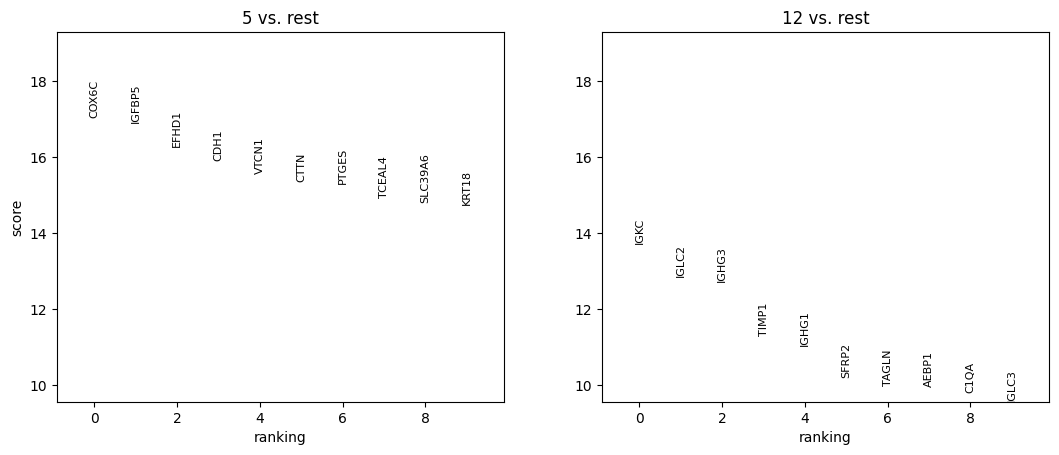

In [ ]:
# 2. 使用 Wilcoxon 检验方法在 'A' 和 'B' 组之间进行差异基因分析
sc.tl.rank_genes_groups(subset_adata, groupby='leiden', method='wilcoxon')

# 3. 可视化每组中的前10个显著差异基因
sc.pl.rank_genes_groups(subset_adata, n_genes=10)

In [13]:
High_12_results = sc.get.rank_genes_groups_df(subset_adata, group='12')
High_12_results['-log10(pvals)'] = -np.log10(High_12_results['pvals'])
High_12_results.loc[(High_12_results['logfoldchanges']>1)&(High_12_results['pvals']<0.05), 'type'] = 'up'
High_12_results.loc[(High_12_results['logfoldchanges']<-1)&(High_12_results['pvals']<0.05), 'type'] = 'down'
High_12_results.loc[ (abs(High_12_results['logfoldchanges'])<=1) | (High_12_results['pvals']>=0.05), 'type'] = 'nosig'

High_12_results.head(10)

names     scores  logfoldchanges         pvals     pvals_adj  \
0   IGKC  13.728986      184.662933  6.807947e-43  8.037989e-40   
1  IGLC2  12.866336       47.620789  6.962788e-38  4.719352e-35   
2  IGHG3  12.730662      109.189140  3.994370e-37  2.396687e-34   
3  TIMP1  11.291799        9.364476  1.440579e-29  3.905678e-27   
4  IGHG1  11.048312       36.986313  2.233750e-28  5.109842e-26   
5  SFRP2  10.186097        4.911110  2.287652e-24  3.474289e-22   
6  TAGLN   9.982659        5.165983  1.815349e-23  2.497879e-21   
7  AEBP1   9.947834        7.526051  2.577313e-23  3.533042e-21   
8   C1QA   9.798811        4.569624  1.139186e-22  1.468146e-20   
9  IGLC3   9.567658        8.862311  1.093543e-21  1.239156e-19   

   -log10(pvals) type  
0      42.166984   up  
1      37.157217   up  
2      36.398552   up  
3      28.841463   up  
4      27.650966   up  
5      23.640610   up  
6      22.741040   up  
7      22.588833   up  
8      21.943405   up  
9      20.961164   up

In [18]:
High_12_results['names'].head(10)

0     IGKC
1    IGLC2
2    IGHG3
3    TIMP1
4    IGHG1
5    SFRP2
6    TAGLN
7    AEBP1
8     C1QA
9    IGLC3
Name: names, dtype: object

In [14]:
High_5_results = sc.get.rank_genes_groups_df(subset_adata, group='5')
High_5_results.head(10)

names     scores  logfoldchanges         pvals     pvals_adj
0    COX6C  17.054073      261.958557  3.260063e-65  1.193216e-60
1   IGFBP5  16.907661      157.848923  3.950782e-64  7.230129e-60
2    EFHD1  16.285305       11.137061  1.255019e-59  1.531165e-55
3     CDH1  15.909482       12.178855  5.446182e-57  4.983393e-53
4    VTCN1  15.558618        7.894378  1.390693e-54  1.018015e-50
5     CTTN  15.361275       18.412441  2.976629e-53  1.815793e-49
6    PTGES  15.295397        6.425548  8.205873e-53  4.290617e-49
7   TCEAL4  14.948015       28.014019  1.604607e-50  7.341277e-47
8  SLC39A6  14.814083       16.473106  1.187993e-49  4.831302e-46
9    KRT18  14.747625       70.817047  3.186840e-49  1.166415e-45

In [19]:
High_5_results['names'].head(10)

0      COX6C
1     IGFBP5
2      EFHD1
3       CDH1
4      VTCN1
5       CTTN
6      PTGES
7     TCEAL4
8    SLC39A6
9      KRT18
Name: names, dtype: object

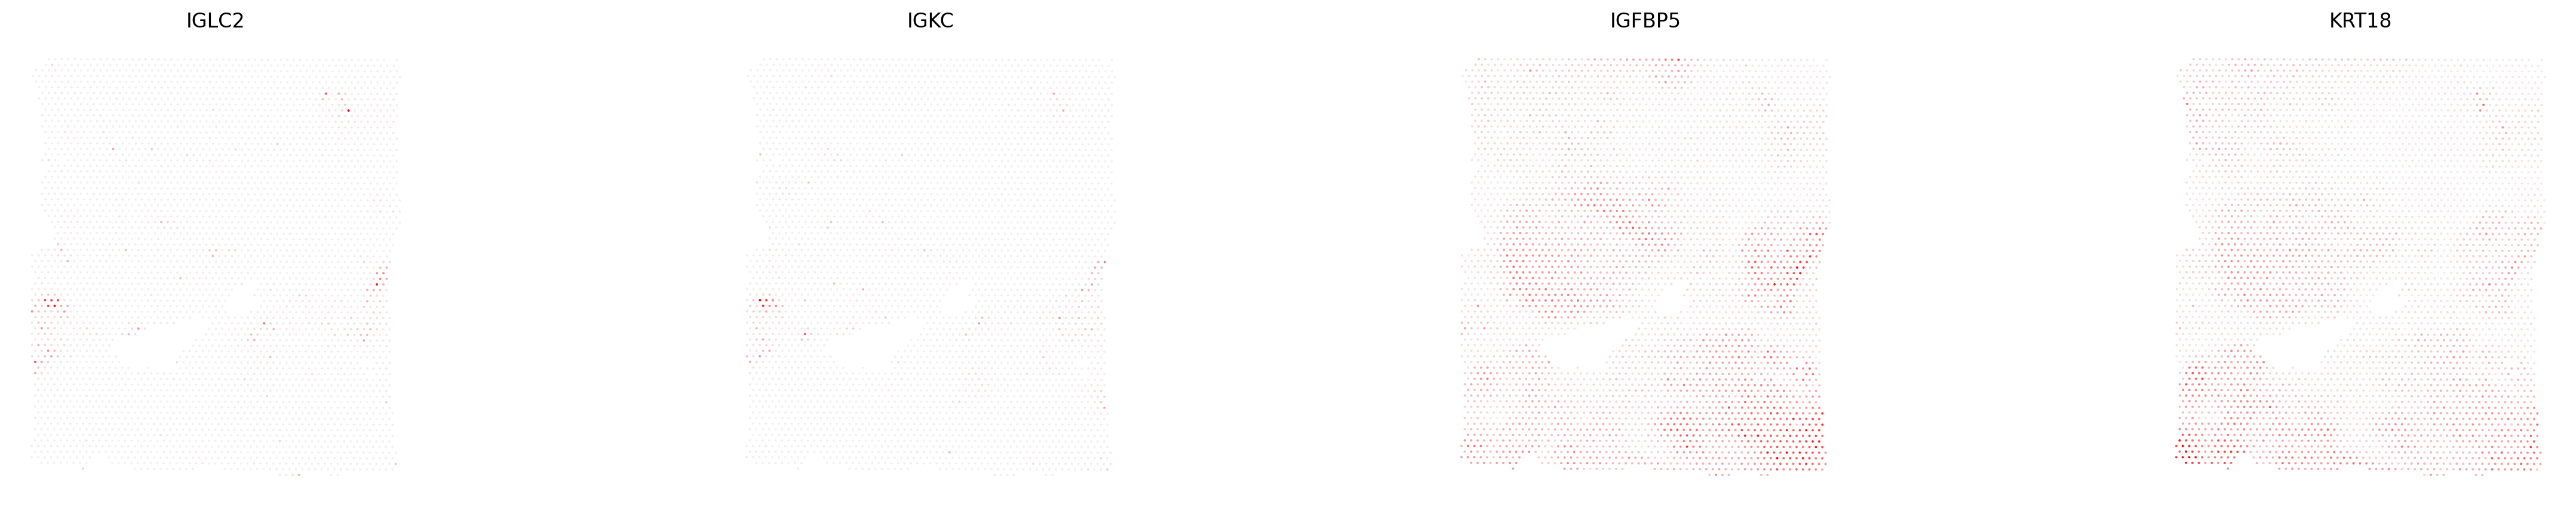

In [29]:
import seaborn as sns
cmap = sns.light_palette("red", n_colors=100, as_cmap=True)

from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (6.4, 5), 'figure.dpi': 200}):

    sc.pl.spatial(adata_1, img_key=None, color=['IGLC2', 'IGKC', 'IGFBP5', 'KRT18'], legend_fontsize=12, ncols=4, frameon=False, spot_size=100, cmap=cmap, colorbar_loc=None)

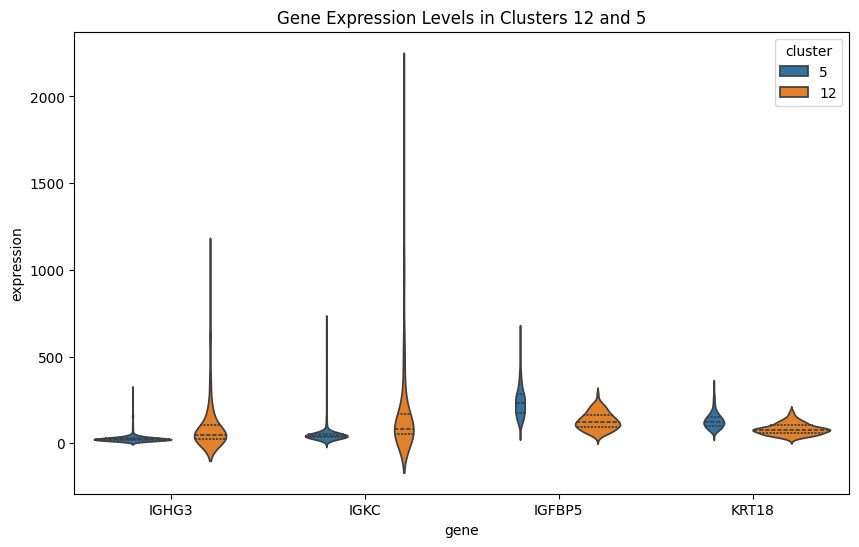

In [50]:
# 假设有基因表达数据在adata对象的.obs里存储
clusters_of_interest = ['12', '5']
genes_of_interest = ['IGHG3', 'IGKC', 'IGFBP5', 'KRT18']

# 筛选聚类为12或5的细胞
selected_cells = adata_com[adata_com.obs['leiden'].isin(clusters_of_interest)]

# 提取这些细胞中感兴趣基因的表达数据
expression_data = selected_cells[:, genes_of_interest].to_df()
expression_data['cluster'] = selected_cells.obs['leiden'].values  # 添加聚类信息

# 将数据从宽格式转换为长格式
expression_data = pd.melt(expression_data, id_vars='cluster', var_name='gene', value_name='expression')

# 绘制小提琴图
plt.figure(figsize=(10, 6))
sns.violinplot(x='gene', y='expression', hue='cluster', data=expression_data, inner='quartile')
plt.title('Gene Expression Levels in Clusters 12 and 5')
plt.show()

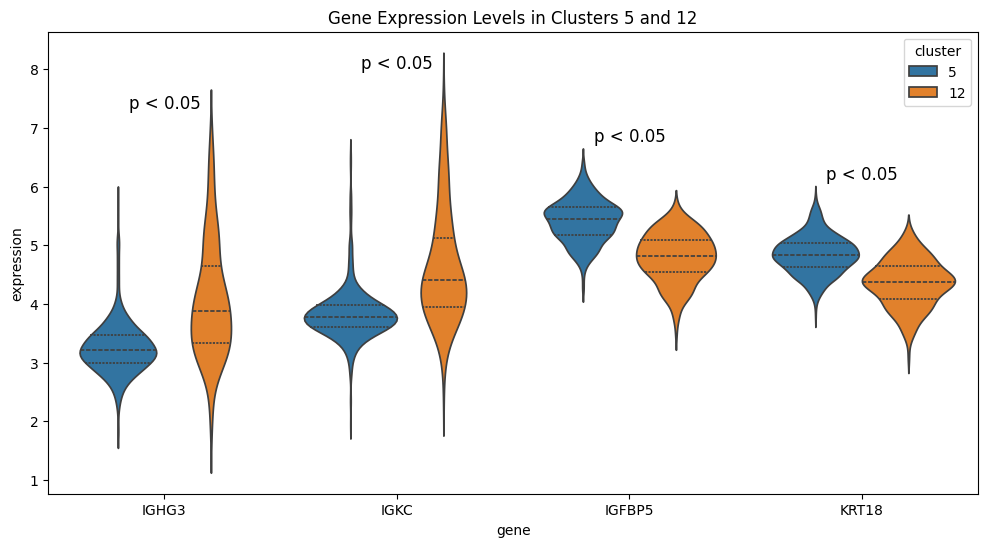

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import mannwhitneyu

# 假设有基因表达数据在adata对象的.obs里存储
clusters_of_interest = ['12', '5']
genes_of_interest = ['IGHG3', 'IGKC', 'IGFBP5', 'KRT18']

# 筛选聚类为12或5的细胞
selected_cells = adata_com[adata_com.obs['leiden'].isin(clusters_of_interest)]

# 提取这些细胞中感兴趣基因的表达数据
expression_data = selected_cells[:, genes_of_interest].to_df()
expression_data[genes_of_interest] = expression_data[genes_of_interest].apply(np.log1p)
expression_data['cluster'] = selected_cells.obs['leiden'].values  # 添加聚类信息

# 将数据从宽格式转换为长格式
expression_data = pd.melt(expression_data, id_vars='cluster', var_name='gene', value_name='expression')

# 计算显著性
p_values = []
for gene in genes_of_interest:
    data_5 = expression_data[(expression_data['gene'] == gene) & (expression_data['cluster'] == '5')]['expression']
    data_12 = expression_data[(expression_data['gene'] == gene) & (expression_data['cluster'] == '12')]['expression']
    _, p_value = mannwhitneyu(data_5, data_12)
    p_values.append((gene, p_value))

# 绘制小提琴图
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='gene', y='expression', hue='cluster', data=expression_data, inner='quartile')

# 添加显著性标记
for i, (gene, p_value) in enumerate(p_values):
    if p_value < 0.05:
        ax.text(i, max(expression_data[expression_data['gene'] == gene]['expression']) * 1.05, 'p < 0.05', 
                ha='center', color='black', fontsize=12)

plt.title('Gene Expression Levels in Clusters 5 and 12')
plt.show()


p = 2.027e-18
p = 3.218e-19
p = 2.117e-16


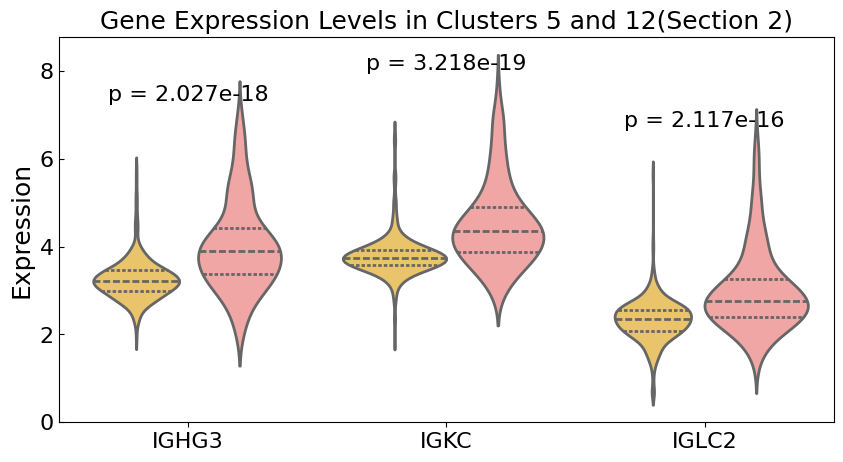

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import mannwhitneyu

# 假设有基因表达数据在adata对象的.obs里存储
clusters_of_interest = ['12', '5']
genes_of_interest = ['IGHG3', 'IGKC', 'IGLC2']

# 筛选聚类为12或5的细胞
selected_cells = adata_1[adata_1.obs['leiden'].isin(clusters_of_interest)]

# 提取这些细胞中感兴趣基因的表达数据
expression_data = selected_cells[:, genes_of_interest].to_df()
expression_data[genes_of_interest] = expression_data[genes_of_interest].apply(np.log1p)
expression_data['cluster'] = selected_cells.obs['leiden'].values  # 添加聚类信息

# 将数据从宽格式转换为长格式
expression_data = pd.melt(expression_data, id_vars='cluster', var_name='gene', value_name='expression')

# 计算显著性
p_values = []
for gene in genes_of_interest:
    data_5 = expression_data[(expression_data['gene'] == gene) & (expression_data['cluster'] == '5')]['expression']
    data_12 = expression_data[(expression_data['gene'] == gene) & (expression_data['cluster'] == '12')]['expression']
    _, p_value = mannwhitneyu(data_5, data_12)
    p_values.append((gene, p_value))

# 绘制小提琴图
plt.figure(figsize=(10, 5))
ax = sns.violinplot(x='gene', y='expression', hue='cluster', data=expression_data, inner='quartile', 
                    palette={'5': "#FFCD56", '12': "#FB9A99"}, linewidth=2)
ax.set_xlabel('', fontsize=0)  # 修改x轴标签字体大小
ax.set_ylabel('Expression', fontsize=18)  # 修改y轴标签字体大小
ax.tick_params(axis='x', labelsize=16)  # 修改x轴刻度字体大小
ax.tick_params(axis='y', labelsize=16, direction='in')
ax.get_legend().remove()
# 添加显著性标记
for i, (gene, p_value) in enumerate(p_values):
    p_text = f"p = {p_value:.3e}"  # 格式化为科学计数法
    print(p_text)
    ax.text(i, max(expression_data[expression_data['gene'] == gene]['expression']) * 1.05, p_text, 
            ha='center', color='black', fontsize=16)

plt.title('Gene Expression Levels in Clusters 5 and 12(Section 2)', fontsize=18)
plt.show()


p = 1.768e-20
p = 2.240e-25
p = 4.906e-23


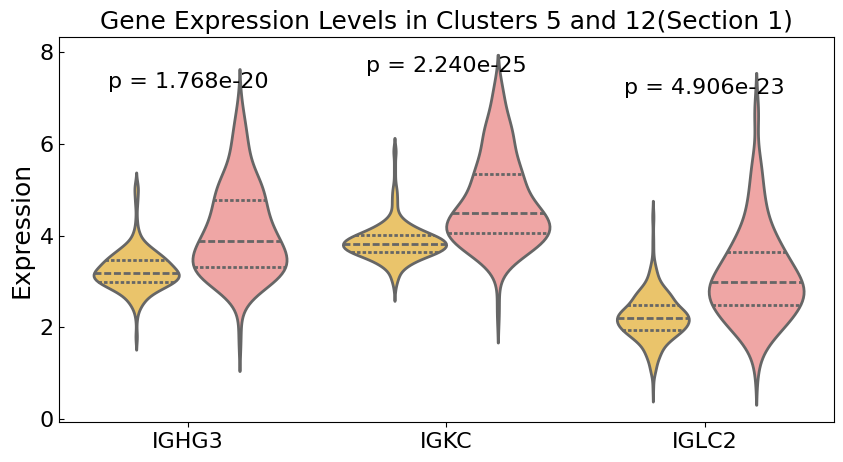

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import mannwhitneyu
import numpy as np

# 假设有基因表达数据在adata对象的.obs里存储
clusters_of_interest = ['12', '5']
genes_of_interest = ['IGHG3', 'IGKC', 'IGLC2']

# 筛选聚类为12或5的细胞
selected_cells = adata_2[adata_2.obs['leiden'].isin(clusters_of_interest)]

# 提取这些细胞中感兴趣基因的表达数据
expression_data = selected_cells[:, genes_of_interest].to_df()
expression_data[genes_of_interest] = expression_data[genes_of_interest].apply(np.log1p)
expression_data['cluster'] = selected_cells.obs['leiden'].values  # 添加聚类信息

# 将数据从宽格式转换为长格式
expression_data = pd.melt(expression_data, id_vars='cluster', var_name='gene', value_name='expression')

# 计算显著性
p_values = []
for gene in genes_of_interest:
    data_5 = expression_data[(expression_data['gene'] == gene) & (expression_data['cluster'] == '5')]['expression']
    data_12 = expression_data[(expression_data['gene'] == gene) & (expression_data['cluster'] == '12')]['expression']
    _, p_value = mannwhitneyu(data_5, data_12)
    p_values.append((gene, p_value))

# 绘制小提琴图
plt.figure(figsize=(10, 5))
ax = sns.violinplot(x='gene', y='expression', hue='cluster', data=expression_data, inner='quartile', 
                    palette={'5': "#FFCD56", '12': "#FB9A99"}, linewidth=2)
ax.set_xlabel('', fontsize=0)  # 修改x轴标签字体大小
ax.set_ylabel('Expression', fontsize=18)  # 修改y轴标签字体大小
ax.tick_params(axis='x', labelsize=16)  # 修改x轴刻度字体大小
ax.tick_params(axis='y', labelsize=16, direction='in')
ax.get_legend().remove()

# 添加真实的显著性标记
for i, (gene, p_value) in enumerate(p_values):
    p_text = f"p = {p_value:.3e}"  # 格式化为科学计数法
    print(p_text)
    ax.text(i, max(expression_data[expression_data['gene'] == gene]['expression']) * 1.05, p_text, 
            ha='center', color='black', fontsize=16)

plt.title('Gene Expression Levels in Clusters 5 and 12(Section 1)', fontsize=18)
plt.show()



In [112]:
Batch_list = [adata_1, adata_2]

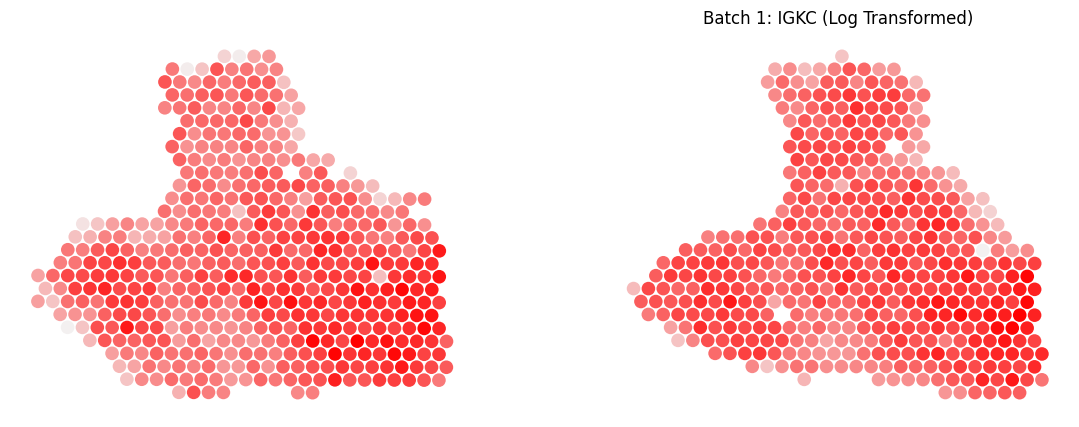

In [141]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt

# 指定感兴趣的基因和聚类
gene_of_interest = 'IGFBP5'
clusters_of_interest = ['5', '12']
cmap = sns.light_palette("red", n_colors=100, as_cmap=True)

# 检查基因是否存在于 Batch_list 数据中
if gene_of_interest in Batch_list[0].var_names and gene_of_interest in Batch_list[1].var_names:
    # 对 Batch_list[0] 和 Batch_list[1] 的目标基因表达进行对数化
    Batch_list[0].obs[gene_of_interest + '_log'] = np.log1p(Batch_list[0][:, gene_of_interest].X.toarray().flatten())
    Batch_list[1].obs[gene_of_interest + '_log'] = np.log1p(Batch_list[1][:, gene_of_interest].X.toarray().flatten())
else:
    print(f"Gene {gene_of_interest} not found in one of the datasets.")
    exit()

# 筛选两个数据集中的感兴趣细胞
batch_0_selected = Batch_list[0][Batch_list[0].obs['leiden'].isin(clusters_of_interest)]
batch_1_selected = Batch_list[1][Batch_list[1].obs['leiden'].isin(clusters_of_interest)]

# 创建 1 行 2 列的子图布局
fig, ax = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'wspace': 0.05})

# 第一个数据集的热力图
sc.pl.spatial(batch_0_selected, img_key=None, color=gene_of_interest + '_log',
              legend_fontsize=12, show=False, ax=ax[0], frameon=False, cmap = cmap, 
              legend_loc = None, 
              spot_size=250, title='')

# 第二个数据集的热力图
sc.pl.spatial(batch_1_selected, img_key=None, color=gene_of_interest + '_log',
              legend_fontsize=12, show=False, ax=ax[1], frameon=False, cmap = cmap,
              legend_loc = None, 
              spot_size=250, title='Batch 1: IGKC (Log Transformed)')

for cax in [ax[0].collections[-1].colorbar.ax, ax[1].collections[-1].colorbar.ax]:
    cax.remove()
# 显示图形
plt.show()


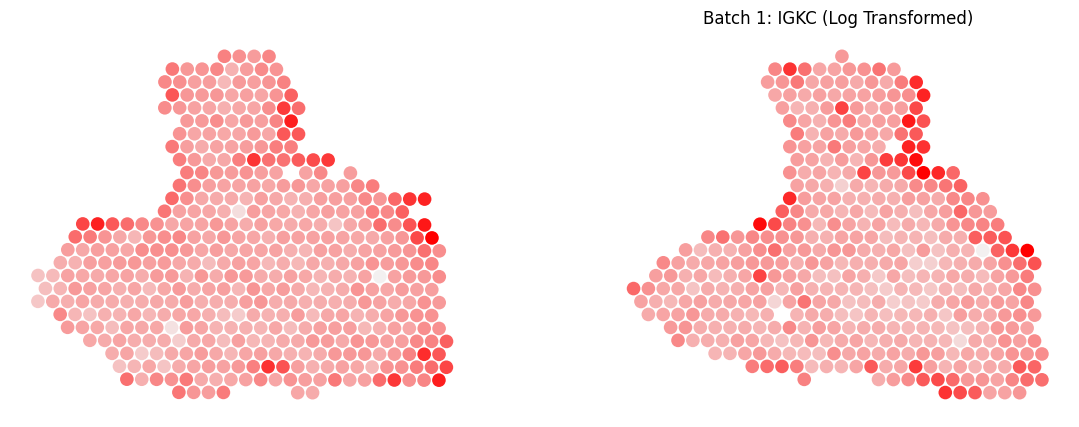

In [148]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt

# 指定感兴趣的基因和聚类
gene_of_interest = 'IGKC'
clusters_of_interest = ['5', '12']
cmap = sns.light_palette("red", n_colors=100, as_cmap=True)

# 检查基因是否存在于 Batch_list 数据中
if gene_of_interest in Batch_list[0].var_names and gene_of_interest in Batch_list[1].var_names:
    # 对 Batch_list[0] 和 Batch_list[1] 的目标基因表达进行对数化
    Batch_list[0].obs[gene_of_interest + '_log'] = np.log1p(Batch_list[0][:, gene_of_interest].X.toarray().flatten())
    Batch_list[1].obs[gene_of_interest + '_log'] = np.log1p(Batch_list[1][:, gene_of_interest].X.toarray().flatten())
else:
    print(f"Gene {gene_of_interest} not found in one of the datasets.")
    exit()

# 筛选两个数据集中的感兴趣细胞
batch_0_selected = Batch_list[0][Batch_list[0].obs['leiden'].isin(clusters_of_interest)]
batch_1_selected = Batch_list[1][Batch_list[1].obs['leiden'].isin(clusters_of_interest)]

# 创建 1 行 2 列的子图布局
fig, ax = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'wspace': 0.05})

# 第一个数据集的热力图
sc.pl.spatial(batch_0_selected, img_key=None, color=gene_of_interest + '_log',
              legend_fontsize=12, show=False, ax=ax[0], frameon=False, cmap = cmap, 
              legend_loc = None, 
              spot_size=250, title='')

# 第二个数据集的热力图
sc.pl.spatial(batch_1_selected, img_key=None, color=gene_of_interest + '_log',
              legend_fontsize=12, show=False, ax=ax[1], frameon=False, cmap = cmap,
              legend_loc = None, 
              spot_size=250, title='Batch 1: IGKC (Log Transformed)')

for cax in [ax[0].collections[-1].colorbar.ax, ax[1].collections[-1].colorbar.ax]:
    cax.remove()
# 显示图形
plt.show()


In [144]:
adata_com.obs['slice_name']

AAACAACGAATAGTTC-1    slice_1
AAACAAGTATCTCCCA-1    slice_1
AAACAATCTACTAGCA-1    slice_1
AAACACCAATAACTGC-1    slice_1
AAACAGAGCGACTCCT-1    slice_1
                       ...   
TTGTTGTGTGTCAAGA-1    slice_2
TTGTTTCACATCCAGG-1    slice_2
TTGTTTCATTAGTCTA-1    slice_2
TTGTTTCCATACAACT-1    slice_2
TTGTTTGTGTAAATTC-1    slice_2
Name: slice_name, Length: 7785, dtype: category
Categories (2, object): ['slice_1', 'slice_2']

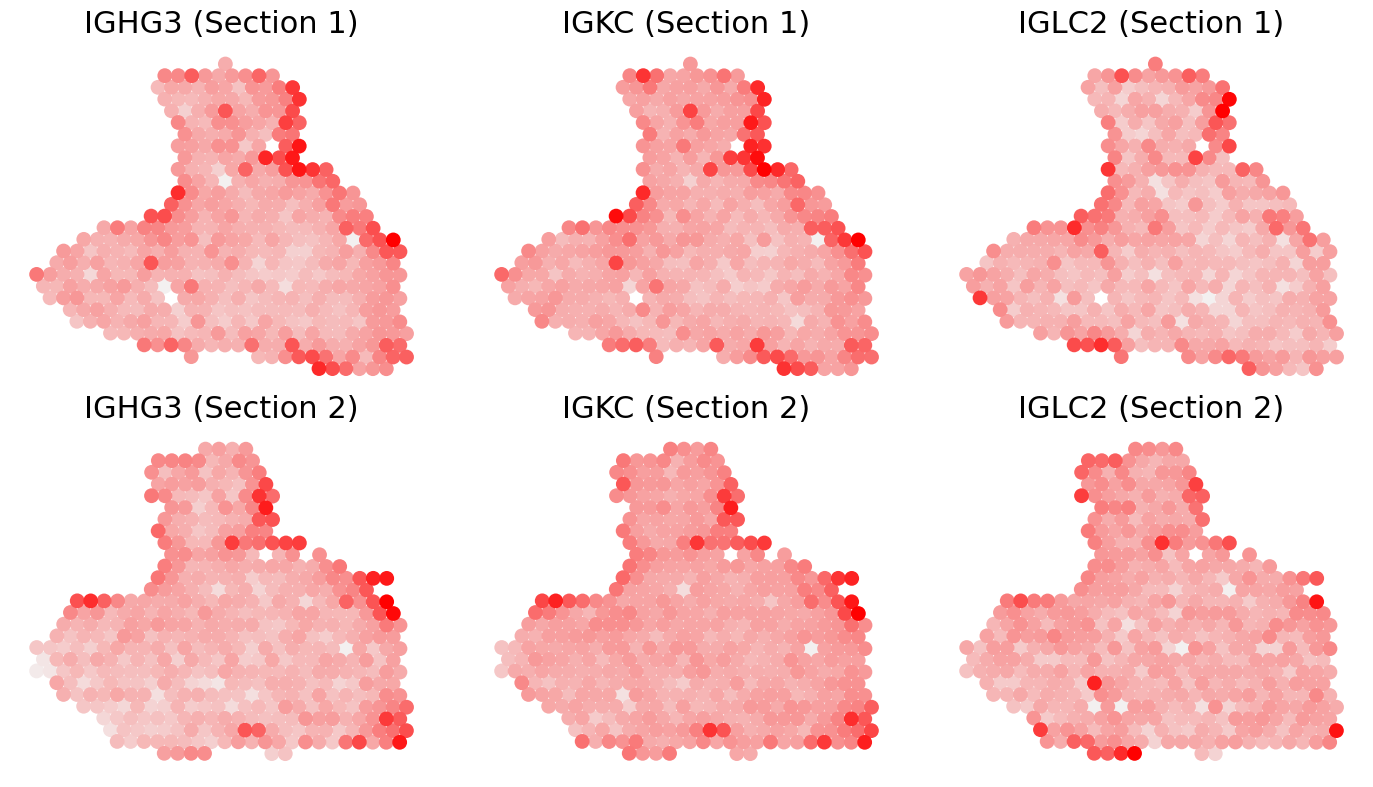

In [177]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 指定感兴趣的基因和聚类
genes_of_interest = ['IGHG3', 'IGKC', 'IGLC2']
clusters_of_interest = ['5', '12']
cmap = sns.light_palette("red", n_colors=100, as_cmap=True)

# 检查每个基因是否存在于 Batch_list 数据中
for gene in genes_of_interest:
    if gene not in Batch_list[0].var_names or gene not in Batch_list[1].var_names:
        print(f"Gene {gene} not found in one of the datasets.")
        exit()

# 对 Batch_list[0] 和 Batch_list[1] 的目标基因表达进行对数化
for gene in genes_of_interest:
    Batch_list[0].obs[gene + '_log'] = np.log1p(Batch_list[0][:, gene].X.toarray().flatten())
    Batch_list[1].obs[gene + '_log'] = np.log1p(Batch_list[1][:, gene].X.toarray().flatten())

# 筛选 Batch_list[0] 和 Batch_list[1] 中的感兴趣细胞
batch_0_selected = Batch_list[0][Batch_list[0].obs['leiden'].isin(clusters_of_interest)]
batch_1_selected = Batch_list[1][Batch_list[1].obs['leiden'].isin(clusters_of_interest)]

# 创建 2 行 3 列的子图布局，行是批次，列是基因
fig, ax = plt.subplots(2, 3, figsize=(18, 10), gridspec_kw={'wspace': 0, 'hspace': 0})

# 对每个基因在两个数据集（Batch 0 和 Batch 1）中绘制热力图
for i, gene in enumerate(genes_of_interest):
    # Batch 0 的热力图
    sc.pl.spatial(batch_1_selected, img_key=None, color=gene + '_log', cmap=cmap, 
                  legend_fontsize=20, show=False, ax=ax[0, i], frameon=False, 
                  spot_size=300, legend_loc=None)
    ax[0, i].set_title(f'{gene} (Section 1)', fontsize=22)
    # Batch 1 的热力图
    sc.pl.spatial(batch_0_selected, img_key=None, color=gene + '_log', cmap=cmap, 
                  legend_fontsize=20, show=False, ax=ax[1, i], frameon=False, 
                  spot_size=300, legend_loc=None)
    ax[1, i].set_title(f'{gene} (Section 2)', fontsize=22)

for cax in [ax[0, i].collections[-1].colorbar.ax for i in range(3)] + [ax[1, i].collections[-1].colorbar.ax for i in range(3)]:
    cax.remove()
# plt.suptitle("Log-transformed Gene Expression Across Batches and Genes", fontsize=20, y=1.02)
plt.show()


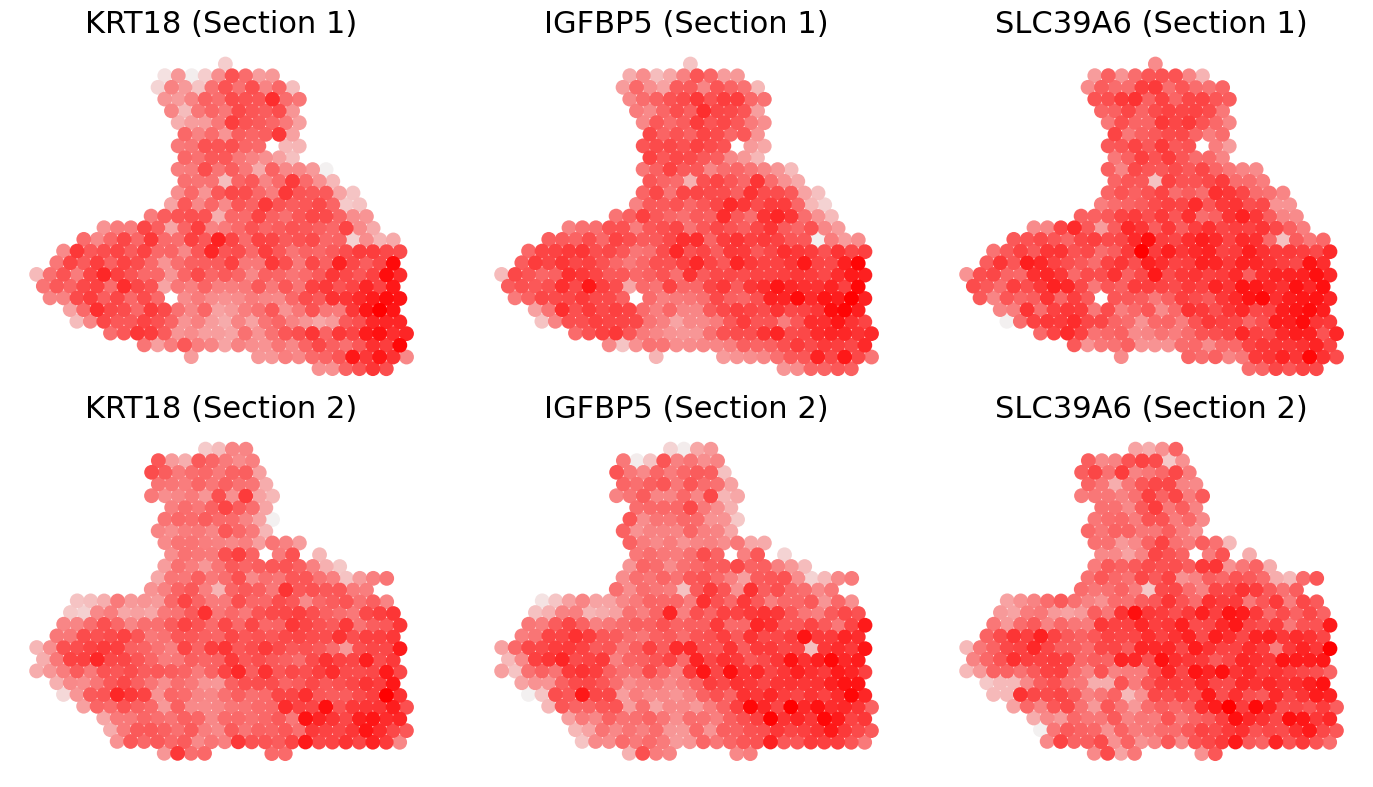

In [ ]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 指定感兴趣的基因和聚类
genes_of_interest = ['KRT18', 'IGFBP5', 'SLC39A6']
clusters_of_interest = ['5', '12']
cmap = sns.light_palette("red", n_colors=100, as_cmap=True)

for gene in genes_of_interest:
    if gene not in Batch_list[0].var_names or gene not in Batch_list[1].var_names:
        print(f"Gene {gene} not found in one of the datasets.")
        exit()
for gene in genes_of_interest:
    Batch_list[0].obs[gene + '_log'] = np.log1p(Batch_list[0][:, gene].X.toarray().flatten())
    Batch_list[1].obs[gene + '_log'] = np.log1p(Batch_list[1][:, gene].X.toarray().flatten())
batch_0_selected = Batch_list[0][Batch_list[0].obs['leiden'].isin(clusters_of_interest)]
batch_1_selected = Batch_list[1][Batch_list[1].obs['leiden'].isin(clusters_of_interest)]

fig, ax = plt.subplots(2, 3, figsize=(18, 10), gridspec_kw={'wspace': 0, 'hspace': 0})

for i, gene in enumerate(genes_of_interest):
    sc.pl.spatial(batch_1_selected, img_key=None, color=gene + '_log', cmap=cmap, 
                  legend_fontsize=20, show=False, ax=ax[0, i], frameon=False, 
                  spot_size=300, legend_loc=None)
    ax[0, i].set_title(f'{gene} (Section 1)', fontsize=22)
    sc.pl.spatial(batch_0_selected, img_key=None, color=gene + '_log', cmap=cmap, 
                  legend_fontsize=20, show=False, ax=ax[1, i], frameon=False, 
                  spot_size=300, legend_loc=None)
    ax[1, i].set_title(f'{gene} (Section 2)', fontsize=22)

for cax in [ax[0, i].collections[-1].colorbar.ax for i in range(3)] + [ax[1, i].collections[-1].colorbar.ax for i in range(3)]:
    cax.remove()
# plt.suptitle("Log-transformed Gene Expression Across Batches and Genes", fontsize=20, y=1.02)
plt.show()


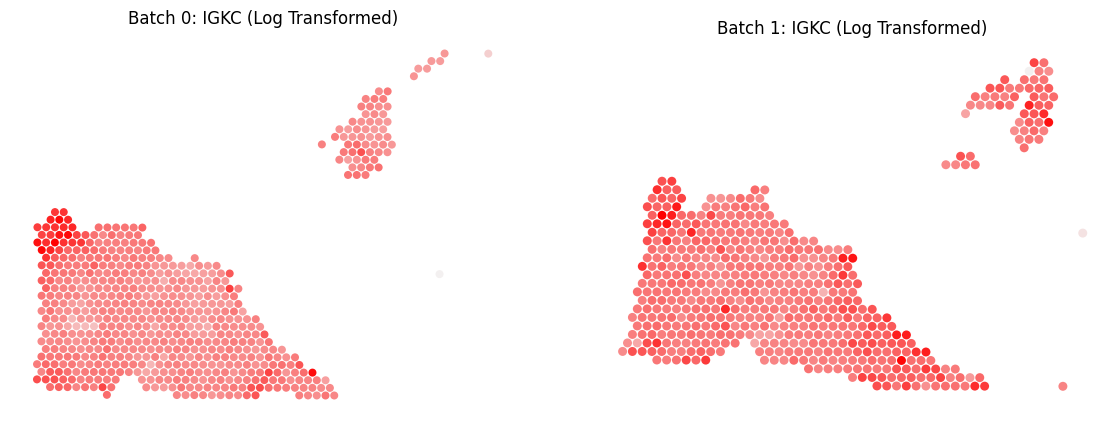

In [135]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt

# 指定感兴趣的基因和聚类
gene_of_interest = 'IGKC'
clusters_of_interest = ['0', '11']
cmap = sns.light_palette("red", n_colors=100, as_cmap=True)

# 检查基因是否存在于 Batch_list 数据中
if gene_of_interest in Batch_list[0].var_names and gene_of_interest in Batch_list[1].var_names:
    # 对 Batch_list[0] 和 Batch_list[1] 的目标基因表达进行对数化
    Batch_list[0].obs[gene_of_interest + '_log'] = np.log1p(Batch_list[0][:, gene_of_interest].X.toarray().flatten())
    Batch_list[1].obs[gene_of_interest + '_log'] = np.log1p(Batch_list[1][:, gene_of_interest].X.toarray().flatten())
else:
    print(f"Gene {gene_of_interest} not found in one of the datasets.")
    exit()

# 筛选两个数据集中的感兴趣细胞
batch_0_selected = Batch_list[0][Batch_list[0].obs['leiden'].isin(clusters_of_interest)]
batch_1_selected = Batch_list[1][Batch_list[1].obs['leiden'].isin(clusters_of_interest)]

# 创建 1 行 2 列的子图布局
fig, ax = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'wspace': 0.05})

# 第一个数据集的热力图
sc.pl.spatial(batch_0_selected, img_key=None, color=gene_of_interest + '_log',
              legend_fontsize=12, show=False, ax=ax[0], frameon=False, cmap = cmap, 
              legend_loc = None, 
              spot_size=250, title='Batch 0: IGKC (Log Transformed)')

# 第二个数据集的热力图
sc.pl.spatial(batch_1_selected, img_key=None, color=gene_of_interest + '_log',
              legend_fontsize=12, show=False, ax=ax[1], frameon=False, cmap = cmap,
              legend_loc = None, 
              spot_size=250, title='Batch 1: IGKC (Log Transformed)')

for cax in [ax[0].collections[-1].colorbar.ax, ax[1].collections[-1].colorbar.ax]:
    cax.remove()
# 显示图形
plt.show()


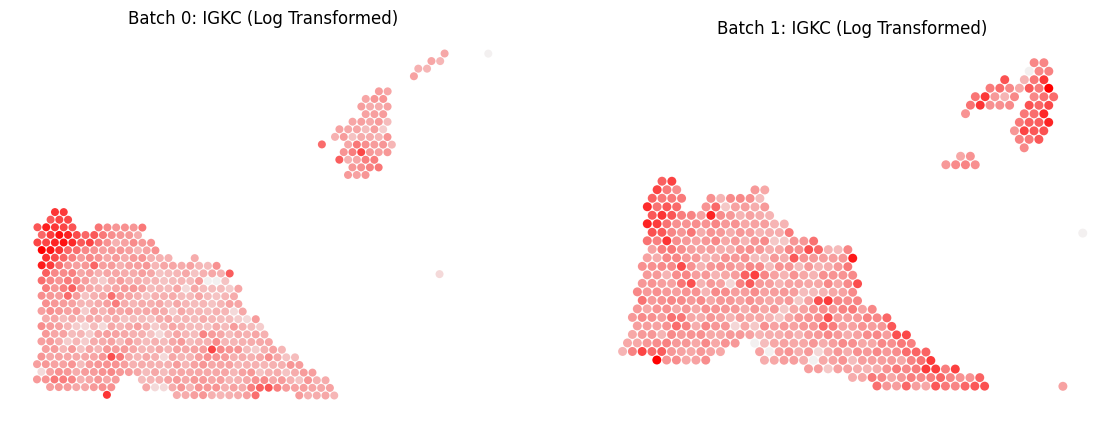

In [138]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt

# 指定感兴趣的基因和聚类
gene_of_interest = 'IGLC2'
clusters_of_interest = ['0', '11']
cmap = sns.light_palette("red", n_colors=100, as_cmap=True)

# 检查基因是否存在于 Batch_list 数据中
if gene_of_interest in Batch_list[0].var_names and gene_of_interest in Batch_list[1].var_names:
    # 对 Batch_list[0] 和 Batch_list[1] 的目标基因表达进行对数化
    Batch_list[0].obs[gene_of_interest + '_log'] = np.log1p(Batch_list[0][:, gene_of_interest].X.toarray().flatten())
    Batch_list[1].obs[gene_of_interest + '_log'] = np.log1p(Batch_list[1][:, gene_of_interest].X.toarray().flatten())
else:
    print(f"Gene {gene_of_interest} not found in one of the datasets.")
    exit()

# 筛选两个数据集中的感兴趣细胞
batch_0_selected = Batch_list[0][Batch_list[0].obs['leiden'].isin(clusters_of_interest)]
batch_1_selected = Batch_list[1][Batch_list[1].obs['leiden'].isin(clusters_of_interest)]

# 创建 1 行 2 列的子图布局
fig, ax = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'wspace': 0.05})

# 第一个数据集的热力图
sc.pl.spatial(batch_0_selected, img_key=None, color=gene_of_interest + '_log',
              legend_fontsize=12, show=False, ax=ax[0], frameon=False, cmap = cmap, 
              legend_loc = None, 
              spot_size=250, title='Batch 0: IGKC (Log Transformed)')

# 第二个数据集的热力图
sc.pl.spatial(batch_1_selected, img_key=None, color=gene_of_interest + '_log',
              legend_fontsize=12, show=False, ax=ax[1], frameon=False, cmap = cmap,
              legend_loc = None, 
              spot_size=250, title='Batch 1: IGKC (Log Transformed)')

for cax in [ax[0].collections[-1].colorbar.ax, ax[1].collections[-1].colorbar.ax]:
    cax.remove()
# 显示图形
plt.show()


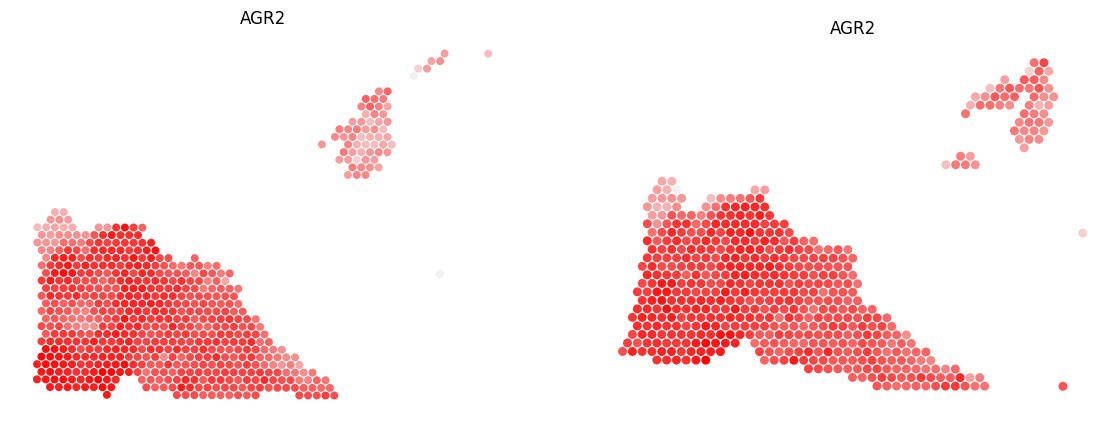

In [133]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt

# 指定感兴趣的基因和聚类
gene_of_interest = 'AGR2'
clusters_of_interest = ['0', '11']
cmap = sns.light_palette("red", n_colors=100, as_cmap=True)

# 检查基因是否存在于 Batch_list 数据中
if gene_of_interest in Batch_list[0].var_names and gene_of_interest in Batch_list[1].var_names:
    # 对 Batch_list[0] 和 Batch_list[1] 的目标基因表达进行对数化
    Batch_list[0].obs[gene_of_interest + '_log'] = np.log1p(Batch_list[0][:, gene_of_interest].X.toarray().flatten())
    Batch_list[1].obs[gene_of_interest + '_log'] = np.log1p(Batch_list[1][:, gene_of_interest].X.toarray().flatten())
else:
    print(f"Gene {gene_of_interest} not found in one of the datasets.")
    exit()

# 筛选两个数据集中的感兴趣细胞
batch_0_selected = Batch_list[0][Batch_list[0].obs['leiden'].isin(clusters_of_interest)]
batch_1_selected = Batch_list[1][Batch_list[1].obs['leiden'].isin(clusters_of_interest)]

# 创建 1 行 2 列的子图布局
fig, ax = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'wspace': 0.05})

# 第一个数据集的热力图
sc.pl.spatial(batch_0_selected, img_key=None, color=gene_of_interest + '_log',
              legend_fontsize=12, show=False, ax=ax[0], frameon=False, cmap = cmap, 
              legend_loc = None, 
              spot_size=250, title='AGR2')

# 第二个数据集的热力图
sc.pl.spatial(batch_1_selected, img_key=None, color=gene_of_interest + '_log',
              legend_fontsize=12, show=False, ax=ax[1], frameon=False, cmap = cmap,
              legend_loc = None, 
              spot_size=250, title='AGR2')

for cax in [ax[0].collections[-1].colorbar.ax, ax[1].collections[-1].colorbar.ax]:
    cax.remove()
# 显示图形
plt.show()


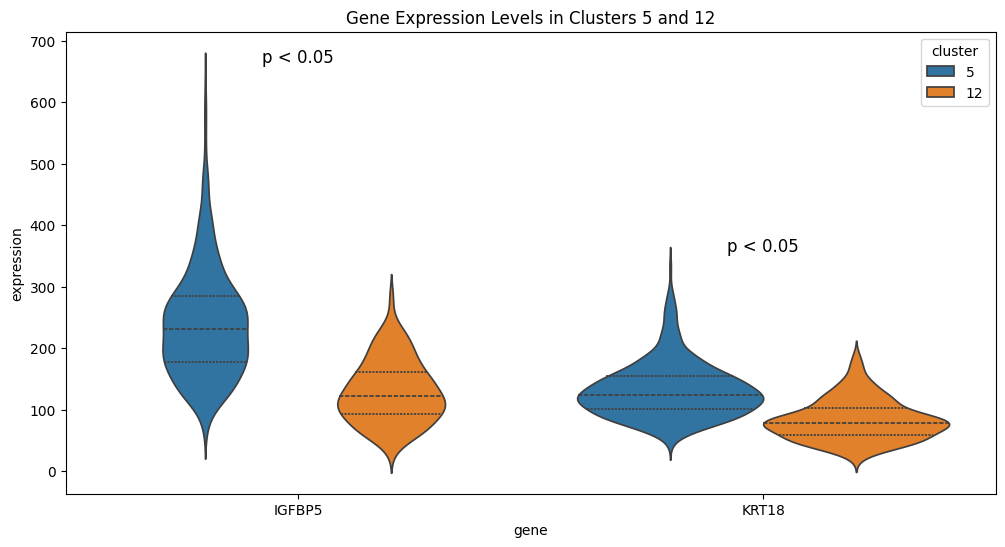

In [ ]:
clusters_of_interest = ['12', '5']
genes_of_interest = ['IGFBP5', 'KRT18']

selected_cells = adata_com[adata_com.obs['leiden'].isin(clusters_of_interest)]

expression_data = selected_cells[:, genes_of_interest].to_df()
expression_data['cluster'] = selected_cells.obs['leiden'].values  # 添加聚类信息
expression_data = pd.melt(expression_data, id_vars='cluster', var_name='gene', value_name='expression')

# 计算显著性
p_values = []
for gene in genes_of_interest:
    data_5 = expression_data[(expression_data['gene'] == gene) & (expression_data['cluster'] == '5')]['expression']
    data_12 = expression_data[(expression_data['gene'] == gene) & (expression_data['cluster'] == '12')]['expression']
    _, p_value = mannwhitneyu(data_5, data_12)
    p_values.append((gene, p_value))

# plot
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='gene', y='expression', hue='cluster', data=expression_data, inner='quartile')
for i, (gene, p_value) in enumerate(p_values):
    if p_value < 0.05:
        ax.text(i, max(expression_data[expression_data['gene'] == gene]['expression']) * 1.05, 'p < 0.05', 
                ha='center', color='black', fontsize=12)

plt.title('Gene Expression Levels in Clusters 5 and 12')
plt.show()


d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\tools\_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


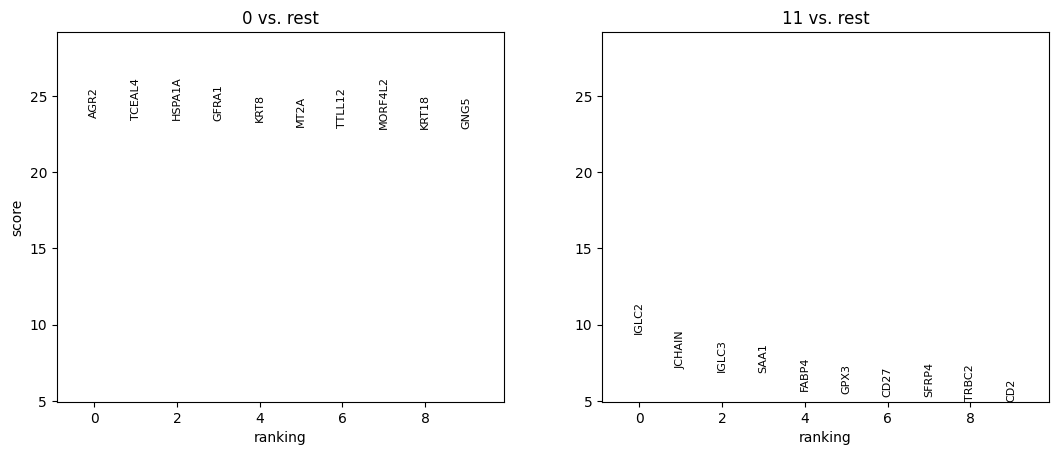

In [55]:
subset_adata = adata_com[adata_com.obs['leiden'].isin(['0', '11'])]
sc.tl.rank_genes_groups(subset_adata, groupby='leiden', method='wilcoxon')
sc.pl.rank_genes_groups(subset_adata, n_genes=10)

In [71]:
High_11_results = sc.get.rank_genes_groups_df(subset_adata, group='11')
High_11_results['-log10(pvals)'] = -np.log10(High_11_results['pvals'])
High_11_results.loc[(High_11_results['logfoldchanges']>1)&(High_11_results['pvals']<0.05), 'type'] = 'up'
High_11_results.loc[(High_11_results['logfoldchanges']<-1)&(High_11_results['pvals']<0.05), 'type'] = 'down'
High_11_results.loc[ (abs(High_11_results['logfoldchanges'])<=1) | (High_11_results['pvals']>=0.05), 'type'] = 'nosig'

High_11_results.head(10)

names    scores  logfoldchanges         pvals     pvals_adj  \
0   IGLC2  9.375796       79.839027  6.865546e-21  6.989870e-20   
1  JCHAIN  7.118822        7.881156  1.088533e-12  7.460935e-12   
2   IGLC3  6.931975       11.352825  4.150037e-12  2.763244e-11   
3    SAA1  6.845640        3.789402  7.613457e-12  4.989438e-11   
4   FABP4  5.675318        3.095896  1.384314e-08  7.581517e-08   
5    GPX3  5.460119        1.353881  4.758150e-08  2.518483e-07   
6    CD27  5.287982        3.002335  1.236734e-07  6.386246e-07   
7   SFRP4  5.263680        2.018714  1.412003e-07  7.259546e-07   
8   TRBC2  5.015013        6.311735  5.302990e-07  2.640745e-06   
9     CD2  4.953086        2.402015  7.304566e-07  3.601703e-06   

   -log10(pvals) type  
0      20.163325   up  
1      11.963158   up  
2      11.381948   up  
3      11.118418   up  
4       7.858765   up  
5       7.322562   up  
6       6.907724   up  
7       6.850164   up  
8       6.275479   up  
9       6.136406   up

In [70]:
High_0_results = sc.get.rank_genes_groups_df(subset_adata, group='0')
High_0_results['-log10(pvals)'] = -np.log10(High_0_results['pvals'])
High_0_results.loc[(High_0_results['logfoldchanges']>1)&(High_0_results['pvals']<0.05), 'type'] = 'up'
High_0_results.loc[(High_0_results['logfoldchanges']<-1)&(High_0_results['pvals']<0.05), 'type'] = 'down'
High_0_results.loc[ (abs(High_0_results['logfoldchanges'])<=1) | (High_0_results['pvals']>=0.05), 'type'] = 'nosig'

High_0_results.head(10)

names     scores  logfoldchanges          pvals      pvals_adj  \
0     AGR2  23.584982       62.884991  5.496366e-123  2.011725e-118   
1   TCEAL4  23.461555       80.055573  1.007591e-121  1.843942e-117   
2   HSPA1A  23.406237       40.090126  3.692275e-121  4.504699e-117   
3    GFRA1  23.356140       33.720791  1.193740e-120  1.092302e-116   
4     KRT8  23.308283      294.973267  3.653753e-120  2.674620e-116   
5     MT2A  22.949085       74.502663  1.504784e-116  9.179433e-113   
6   TTLL12  22.935335       22.816612  2.064101e-116  1.079259e-112   
7  MORF4L2  22.866268       47.539764  1.006855e-115  4.606487e-112   
8    KRT18  22.859659      179.114532  1.171408e-115  4.763857e-112   
9     GNG5  22.852411       28.940556  1.382897e-115  5.061542e-112   

   -log10(pvals) type  
0     122.259924   up  
1     120.996716   up  
2     120.432706   up  
3     119.923090   up  
4     119.437261   up  
5     115.822526   up  
6     115.685269   up  
7     114.997033   up  
8     114.931292   up  
9     114.859210   up

In [58]:
High_11_results['names'].head(10)

0     IGLC2
1    JCHAIN
2     IGLC3
3      SAA1
4     FABP4
5      GPX3
6      CD27
7     SFRP4
8     TRBC2
9       CD2
Name: names, dtype: object

In [59]:
High_0_results['names'].head(10)

0       AGR2
1     TCEAL4
2     HSPA1A
3      GFRA1
4       KRT8
5       MT2A
6     TTLL12
7    MORF4L2
8      KRT18
9       GNG5
Name: names, dtype: object

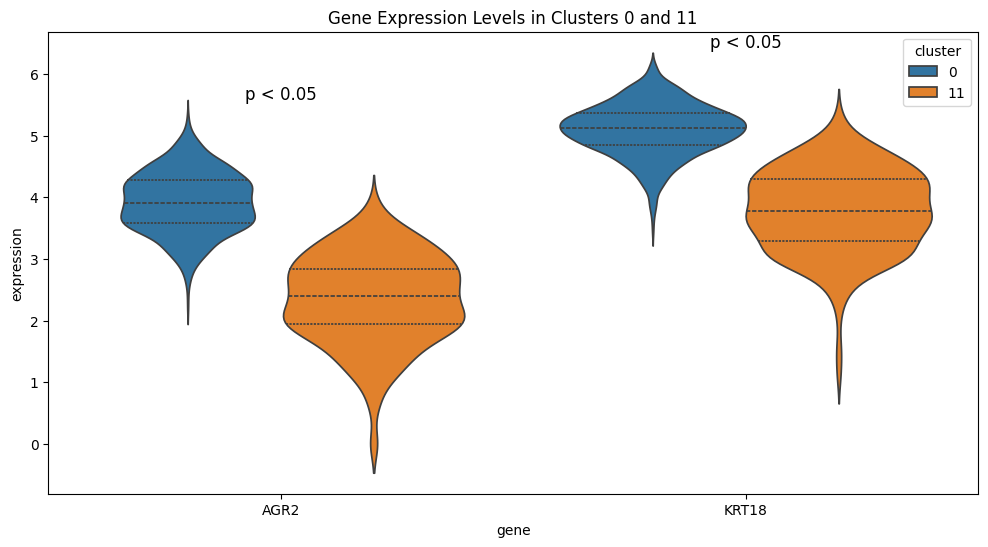

In [76]:
clusters_of_interest = ['11', '0']
genes_of_interest = ['AGR2', 'KRT18']

selected_cells = adata_com[adata_com.obs['leiden'].isin(clusters_of_interest)]
# 提取基因表达数据
expression_data = selected_cells[:, genes_of_interest].to_df()
# 对表达数据进行对数化
expression_data[genes_of_interest] = expression_data[genes_of_interest].apply(np.log1p)
expression_data['cluster'] = selected_cells.obs['leiden'].values  # 添加聚类信息
expression_data = pd.melt(expression_data, id_vars='cluster', var_name='gene', value_name='expression')

# 计算显著性
p_values = []
for gene in genes_of_interest:
    data_5 = expression_data[(expression_data['gene'] == gene) & (expression_data['cluster'] == '0')]['expression']
    data_12 = expression_data[(expression_data['gene'] == gene) & (expression_data['cluster'] == '11')]['expression']
    _, p_value = mannwhitneyu(data_5, data_12)
    p_values.append((gene, p_value))

# plot
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='gene', y='expression', hue='cluster', data=expression_data, inner='quartile')
for i, (gene, p_value) in enumerate(p_values):
    if p_value < 0.05:
        ax.text(i, max(expression_data[expression_data['gene'] == gene]['expression']) * 1.05, 'p < 0.05', 
                ha='center', color='black', fontsize=12)

plt.title('Gene Expression Levels in Clusters 0 and 11')
plt.show()

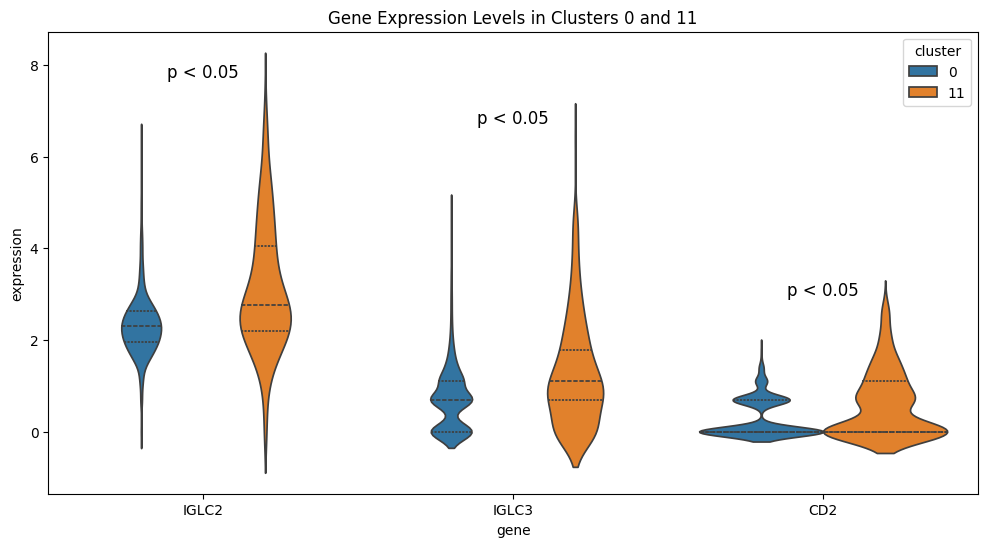

In [129]:
clusters_of_interest = ['11', '0']
genes_of_interest = ['IGLC2', 'IGLC3', 'CD2']

selected_cells = adata_com[adata_com.obs['leiden'].isin(clusters_of_interest)]

expression_data = selected_cells[:, genes_of_interest].to_df()
expression_data[genes_of_interest] = expression_data[genes_of_interest].apply(np.log1p)
expression_data['cluster'] = selected_cells.obs['leiden'].values  # 添加聚类信息
expression_data = pd.melt(expression_data, id_vars='cluster', var_name='gene', value_name='expression')

# 计算显著性
p_values = []
for gene in genes_of_interest:
    data_5 = expression_data[(expression_data['gene'] == gene) & (expression_data['cluster'] == '0')]['expression']
    data_12 = expression_data[(expression_data['gene'] == gene) & (expression_data['cluster'] == '11')]['expression']
    _, p_value = mannwhitneyu(data_5, data_12)
    p_values.append((gene, p_value))

# plot
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='gene', y='expression', hue='cluster', data=expression_data, inner='quartile')
for i, (gene, p_value) in enumerate(p_values):
    if p_value < 0.05:
        ax.text(i, max(expression_data[expression_data['gene'] == gene]['expression']) * 1.05, 'p < 0.05', 
                ha='center', color='black', fontsize=12)

plt.title('Gene Expression Levels in Clusters 0 and 11')
plt.show()